In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


df = pd.read_csv('../model_target_simple/Feature_Importance/General_allcols_withTarget.csv') # df = vip 파일

C:\Users\johnh\AppData\Local\Temp\ipykernel_14360\3566157223.py:9: DtypeWarning: Columns (3346,3347,3348,3349,3350,3357,3358,3359,3360,3361,3362,3393,3394,3395,3396,3397,3398,3867,3868,3869,3870,3871,3872) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../model_target_simple/Feature_Importance/General_allcols_withTarget.csv') # df = vip 파일


In [7]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Columns: 4977 entries, 발급회원번호 to 혜택수혜율_B0M_12
dtypes: float64(1507), int64(3283), object(187)
memory usage: 1.5+ GB


🧹 데이터 정리 중...
   - 초기 변수 개수: 4,786 개
   - 무의미한(값 고정) 컬럼 제거 후: 4,087 개
   - (제거된 컬럼 수: 699 개)

🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)


C:\Users\johnh\AppData\Local\Temp\ipykernel_14360\493689529.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')


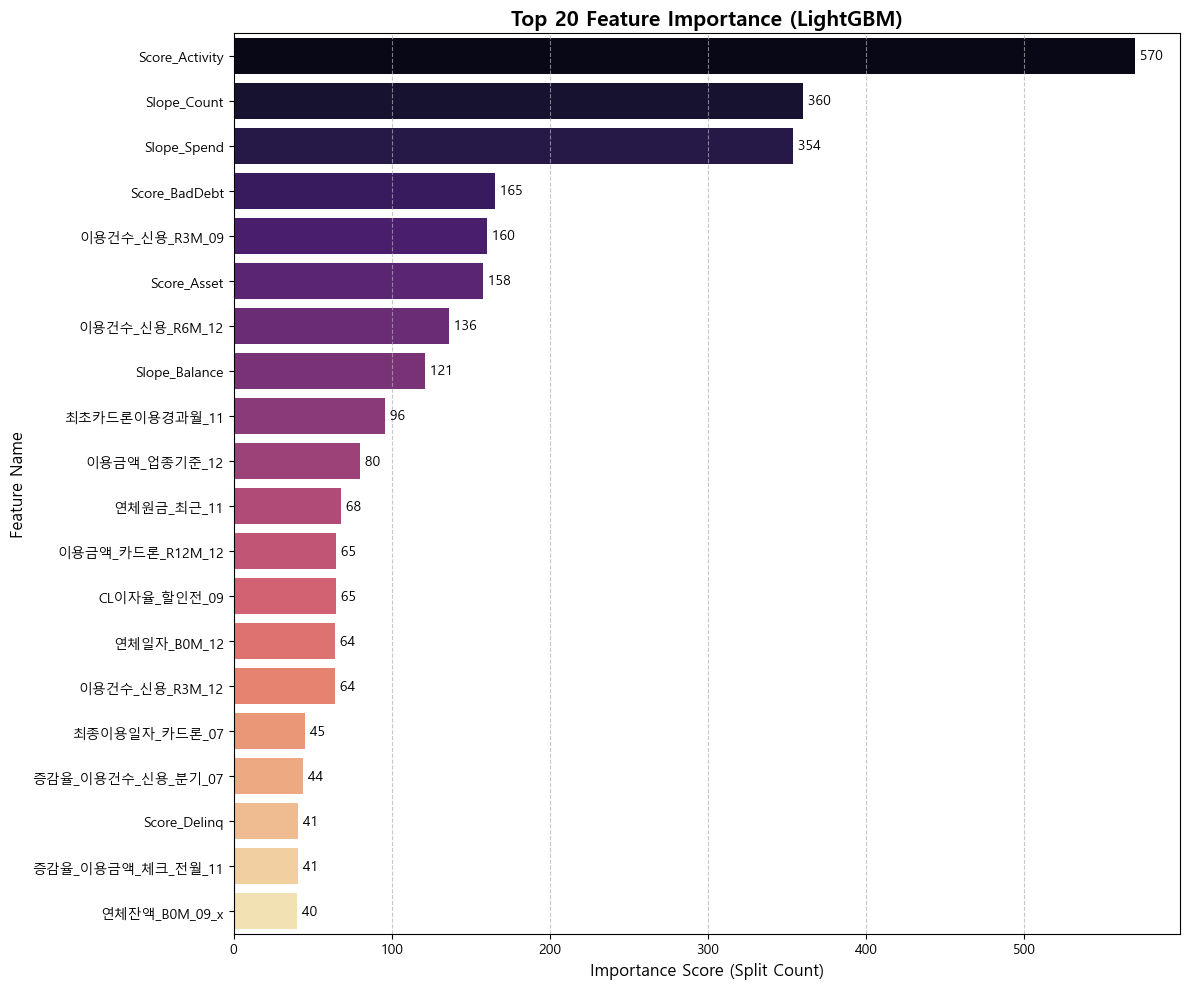

📊 분석 완료.
   - 최종 사용된 변수: 4,087 개
   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb  # Random Forest 대신 사용 (훨씬 빠름)


# General
# =============================================================================
# [Step 1] 데이터 다이어트 (전처리)
# =============================================================================
print("🧹 데이터 정리 중...")

# 1. 분석 제외 대상 컬럼 설정
# (식별자, 타겟, 이미 생성한 파생변수 결과값 등은 제외)
exclude_cols = ['발급회원번호', 'Target', 'Churn_Segment', 'Risk_Count',
                'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
                'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score']

# 2. 수치형 데이터만 우선 선택 (속도 및 에러 방지)
# 5000개 중 문자열(Object)이 섞여 있으면 인코딩하느라 시간이 오래 걸리므로, 일단 수치형 위주로 봅니다.
df_numeric = df.select_dtypes(include=[np.number])
X = df_numeric.drop(columns=[c for c in exclude_cols if c in df_numeric.columns], errors='ignore')
y = df['Target']

print(f"   - 초기 변수 개수: {X.shape[1]:,} 개")

# 무한대(inf)와 결측치(NaN)를 모두 0으로 안전하게 대체합니다.
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

# 3. [핵심] 분산이 0인(모든 값이 똑같은) 컬럼 제거
# 예: 모든 고객의 '가입비'가 0원이라면, 이 변수는 분석 가치가 없습니다.
selector = VarianceThreshold(threshold=0)
selector.fit(X)

# 선택된 컬럼만 남기기
X_reduced = X.loc[:, selector.get_support()]

print(f"   - 무의미한(값 고정) 컬럼 제거 후: {X_reduced.shape[1]:,} 개")
print(f"   - (제거된 컬럼 수: {X.shape[1] - X_reduced.shape[1]:,} 개)")

# =============================================================================
# [Step 2] LightGBM으로 고속 학습
# =============================================================================
print("\n🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)")

# LGBM 설정: 속도 위주 세팅
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,      # 나무의 개수
    learning_rate=0.1,     # 학습률
    num_leaves=31,         # 잎의 개수 (복잡도 제어)
    n_jobs=-1,             # 모든 CPU 코어 사용
    random_state=42,
    verbose=-1             # 경고 메시지 숨김
)

lgbm_model.fit(X_reduced, y)

# =============================================================================
# [Step 3] 중요도 시각화
# =============================================================================

# 중요도 추출
feature_imp_gen = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': lgbm_model.feature_importances_
})

# 중요도 0인 변수 제외하고, 상위 20개 정렬
top_20_features = feature_imp_gen[feature_imp_gen['Importance'] > 0].sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')

plt.title('Top 20 Feature Importance (LightGBM)', fontsize=15, fontweight='bold')
plt.xlabel('Importance Score (Split Count)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 수치 텍스트 표시
for i, v in enumerate(top_20_features['Importance']):
    plt.text(v, i, f' {int(v)}', va='center', fontsize=10)

plt.tight_layout()
# plt.savefig('Feature_Importance_LightGBM.png', dpi=300)
plt.show()

print("📊 분석 완료.")
print(f"   - 최종 사용된 변수: {X_reduced.shape[1]:,} 개")
print("   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.")

In [10]:
feature_imp_gen['Importance'] = feature_imp_gen['Importance'].sort_values(ascending=False, ignore_index=True)


In [11]:
# =============================================================================
# [Step 6] Feature Selection (Top 100) - 메모리 반환 버전 (저장 X)
# =============================================================================

def select_top100_features(source_df, importance_df):
    print(f"[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...")
    
    # ---------------------------------------------------------
    # 1. Feature Importance 필터링
    # ---------------------------------------------------------
    # (안전장치) 내림차순 정렬
    df_imp_sorted = importance_df.sort_values(by='Importance', ascending=False)
    
    # 조건: Importance > 0
    df_imp_active = df_imp_sorted[df_imp_sorted['Importance'] > 0]
    
    # 상위 100개 추출
    top_features = df_imp_active.head(100)['Feature'].tolist()
    
    print(f"  - 중요도 > 0 인 컬럼 수: {len(df_imp_active)}개")
    print(f"  - 최종 선정된 Feature 수 (Top 100): {len(top_features)}개")
    
    if len(top_features) == 0:
        print("  [!] 경고: 조건에 맞는 Feature가 없습니다.")
        return None

    # ---------------------------------------------------------
    # 2. 원본 데이터(source_df)에서 컬럼 선택
    # ---------------------------------------------------------
    # 필수 컬럼 정의 (Target, ID 등 분석에 꼭 필요한 컬럼)
    essential_cols = ['발급회원번호', 'Target']
    
    # 원본 데이터에 실제 존재하는 컬럼인지 확인 (KeyError 방지)
    valid_features = [col for col in top_features if col in source_df.columns]
    
    # 제외된 컬럼 확인
    missing_cols = set(top_features) - set(valid_features)
    if missing_cols:
        print(f"  [!] 주의: 원본 데이터에 없는 컬럼 {len(missing_cols)}개가 제외되었습니다.")
    
    # 최종 선택 컬럼 리스트 생성 (순서: 필수 -> 중요도순)
    final_cols = essential_cols + valid_features
    
    # 중복 제거 (필수 컬럼이 중요도 리스트에도 있을 경우 대비)
    final_cols = list(dict.fromkeys(final_cols))
    
    # ---------------------------------------------------------
    # 3. 데이터 슬라이싱 및 반환
    # ---------------------------------------------------------
    try:
        df_result = source_df[final_cols].copy()
        print(f"  ✅ 데이터 추출 완료. Shape: {df_result.shape}")
        return df_result
        
    except Exception as e:
        print(f"  [!] 추출 중 오류 발생: {e}")
        return None

# =============================================================================
# [실행]
# =============================================================================

# (안전장치) df_2 확인 (앞선 단계에서 Target이 병합된 데이터프레임)
if 'df_2' not in locals():
    if 'df' in locals():
        print("⚠ 'df_2'가 없어 현재 메모리의 'df'를 사용합니다.")
        df_2 = df.copy()
    else:
        print("⛔ 오류: 데이터프레임('df' 또는 'df_2')이 정의되지 않았습니다.")

# 함수 실행 (결과를 df_final 변수에 저장)
if 'feature_imp_gen' in locals() and 'df_2' in locals():
    # 파일로 저장하지 않고, 변수(df_final)로 받아서 바로 사용
    df_final = select_top100_features(df_2, feature_imp_gen)
    
    # 결과 확인
    if df_final is not None:
        print("\n[Result Sample]")
        print(df_final.head())
else:
    print("⛔ 'feature_imp_gen' 변수(중요도 데이터프레임)가 정의되지 않았습니다.")

⚠ 'df_2'가 없어 현재 메모리의 'df'를 사용합니다.
[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...
  - 중요도 > 0 인 컬럼 수: 422개
  - 최종 선정된 Feature 수 (Top 100): 100개
  ✅ 데이터 추출 완료. Shape: (40106, 102)

[Result Sample]
        발급회원번호  Target  이용건수_신용_B0M_07_x  이용건수_신용_B0M_08_x  이용건수_신용_B0M_09_x  \
0  SYN_1000048       0                28                25                27   
1  SYN_1000194       0                 3                 3                 0   
2  SYN_1000201       0                10                12                 7   
3  SYN_1000250       0                 1                 1                -1   
4  SYN_1000338       0                 3                 5                 3   

   이용건수_신용_B0M_10_x  이용건수_신용_B0M_11_x  이용건수_신용_B0M_12_x  이용금액_신용_B0M_07_x  \
0                33                34                35            640723   
1                 8                 5                 4            351844   
2                 8                 2                 3            289406   
3                

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Columns: 102 entries, 발급회원번호 to 입회일자_신용_12
dtypes: float64(40), int64(61), object(1)
memory usage: 31.2+ MB


In [13]:
import pandas as pd

# 1. 모든 열(Column)을 다 보여주기 (생략 ... 방지)
pd.set_option('display.max_columns', None)

# 2. 모든 행(Row)을 다 보여주기 (데이터가 너무 많으면 브라우저가 느려질 수 있으니 주의)
# pd.set_option('display.max_rows', None)  # 필요할 때만 주석 해제해서 사용하세요

# 3. 컬럼 내의 텍스트가 길어도 자르지 않고 다 보여주기
pd.set_option('display.max_colwidth', None)

# 4. 가로 폭을 넓게 설정 (줄바꿈 방지)
pd.set_option('display.width', 1000)

print("✅ 출력 제한 옵션이 해제되었습니다.")

✅ 출력 제한 옵션이 해제되었습니다.



==================== [GENERAL] Training Start (Balanced) ====================
 - 학습 Feature 수: 90개
 - 학습 데이터 샘플 수: 40106개
✅ 학습 완료 (소요시간: 1.23초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.9640
 - F1 Score  : 0.9666
 - ROC-AUC   : 0.9876
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7547
           1       0.64      0.88      0.74       475

    accuracy                           0.96      8022
   macro avg       0.82      0.93      0.86      8022
weighted avg       0.97      0.96      0.97      8022



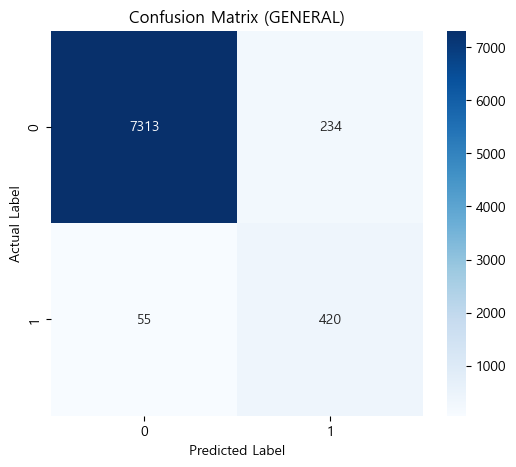

<Figure size 1000x800 with 0 Axes>

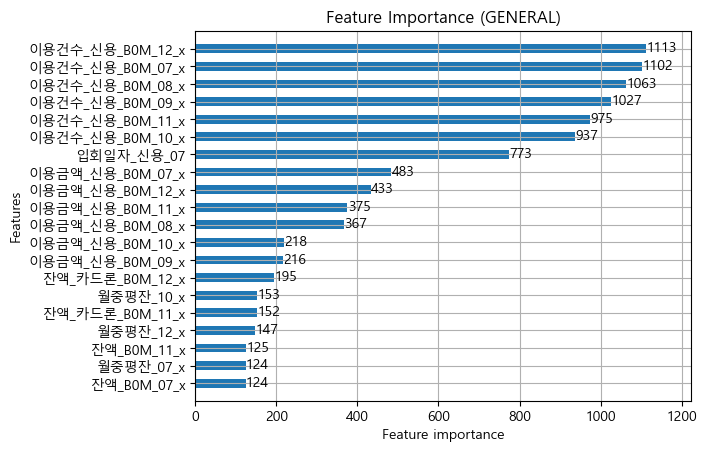

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# =============================================================================
# [Step 7] LightGBM 모델 학습 (General Only)
# =============================================================================

def train_eval_lgbm_general(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Balanced) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 제거 (타겟 유출 방지)
    # Target과 발급회원번호는 학습에 직접 쓰지 않으므로 분리
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        # 아래 변수들은 Feature Importance 단계에서 이미 걸러졌을 수 있으나 안전장치로 포함
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    
    # 실제 학습에 사용할 Feature(X)와 Target(y) 분리
    # Target은 반드시 존재해야 함
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None

    y = df_train['Target']
    
    # Leakage 컬럼 제외 및 수치형 데이터만 선택
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    X = df_train.drop(columns=cols_to_drop)
    X = X.select_dtypes(include=['number']) 
    
    print(f" - 학습 Feature 수: {X.shape[1]}개")
    print(f" - 학습 데이터 샘플 수: {X.shape[0]}개")
    
    # 3. Train / Test Split
    # stratify=y를 통해 이탈/비이탈 비율을 유지하며 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4. LightGBM 파라미터 설정
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced' # [핵심] 불균형 데이터 자동 보정
    }
    
    # GPU 설정 (필요시 활성화)
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # 다중 클래스일 경우 weighted 권장 (2진분류도 호환)
    # AUC는 2진 분류일 때만 계산 (Target 1, 2인 경우 0, 1로 매핑 필요할 수 있음)
    try:
        # Target이 1, 2로 되어있다면 2를 0으로 인식하게 하거나 pos_label 지정 필요
        # 여기서는 모델이 알아서 클래스를 인식하므로 그대로 진행 시도
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0 # 에러 시 0 처리

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

# =============================================================================
# [실행] General 모델 학습
# =============================================================================

# df_final: 앞선 [Step 6]에서 Top 100 Feature로 추출된 데이터프레임
if 'df_final' in locals() and df_final is not None:
    model_gen, res_gen = train_eval_lgbm_general(
        input_data=df_final, 
        group_name='GENERAL', 
        device_type='cpu' # GPU 사용 시 'gpu'로 변경
    )
else:
    print("⛔ 'df_final' 데이터가 준비되지 않았습니다. 앞선 코드를 먼저 실행해주세요.")